**TODO**

change variables to be consistant with VOC or VOC+demo

 ----------------------------------------------
Goals
-
1. Exploring models
2. Using a train test split
3. Testing without demographics initially and then including demographics
4. Comparing how inclusion of demographics changed anything (if at all)
5. Summarizing
 ----------------------------------------------

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from sklearn.feature_selection import RFE
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_curve, auc, roc_auc_score

 ----------------------------------------------
 **Exploring models**
-
 ----------------------------------------------

In [2]:
# Remove identifiers and non-feature columns. Right now only worrying about VOCs, not demographics yet.
df_main = pd.read_csv("df_main_normalized.csv")

y = df_main["TB Status"]  # Target
X = df_main.drop(columns=["PID", "TB Status", "Age", "BMI", "HIV Status"])  # Features without demographics for now

In [3]:
# QC Checks
print(np.isnan(X).sum().sum())
print(np.isinf(X).sum().sum())
# print(X.describe())
print((X.std() == 0).sum())  # Number of zero-variance features

0
0
0


Above sets up the data and removes the target from the features.

The next cell below is to figure out what number of features is appropriate for SVM-RFE.

In [4]:
# I trust my model and the ROC-AUC is stable so I'm going to supress some warnings for a cleaner output
import warnings
warnings.filterwarnings("ignore", message=".*invalid value encountered in matmul.*")
warnings.filterwarnings("ignore", message=".*divide by zero encountered in matmul.*")
warnings.filterwarnings("ignore", message=".*overflow encountered in matmul.*")

****SVM-RFE SECTION****

5 features → ROC-AUC: 0.770
10 features → ROC-AUC: 0.766
15 features → ROC-AUC: 0.786
20 features → ROC-AUC: 0.756
25 features → ROC-AUC: 0.738
30 features → ROC-AUC: 0.747
35 features → ROC-AUC: 0.756
40 features → ROC-AUC: 0.756


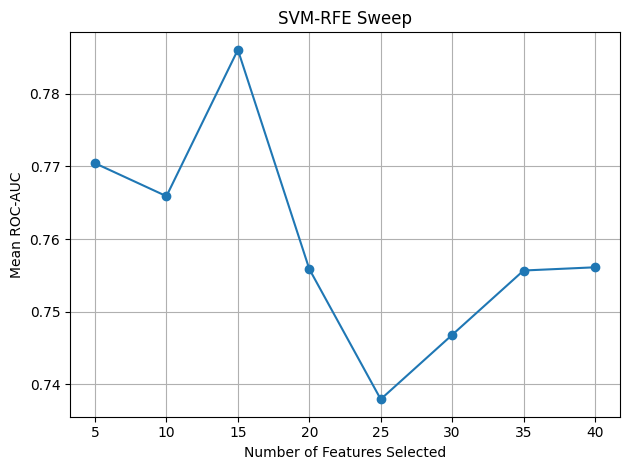

In [5]:
# Config
svc = LinearSVC(C=1, max_iter=10000)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
feature_counts = list(range(5, min(41, X.shape[1]), 5))
scores = []

# Sweep
for n in feature_counts:
    pipeline = Pipeline([
        ("feature_selection", RFE(estimator=svc, n_features_to_select=n)),
        ("classifier", svc)
    ])
    score = cross_val_score(pipeline, X, y, cv=cv, scoring='roc_auc').mean()
    scores.append(score)
    print(f"{n} features → ROC-AUC: {score:.3f}")

# Plot
plt.plot(feature_counts, scores, marker='o')
plt.xlabel("Number of Features Selected")
plt.ylabel("Mean ROC-AUC")
plt.title("SVM-RFE Sweep")
plt.grid(True)
plt.tight_layout()
plt.show()

**Note to Self** I'm getting a ton of runtime warnings related to divide by zero encoutered. I'm guessing this is due to zero variance in some columns maybe? Everything normalized well so I dont think it's a skew issue. Going to try to run a variance filter.

Tried the variance filter. it didn't drop anything so these errors are something else...



Based off of the ROC-AUC, we are selecting 5 features. 15 does show better mean ROC, but looking for a simpler model


SVM-RFE: ROC-AUC vs. C Sweep (5 features)
C=0.001  → Mean ROC-AUC: 0.8694
C=0.01   → Mean ROC-AUC: 0.8454
C=0.1    → Mean ROC-AUC: 0.7809
C=1      → Mean ROC-AUC: 0.7704
C=10     → Mean ROC-AUC: 0.7665


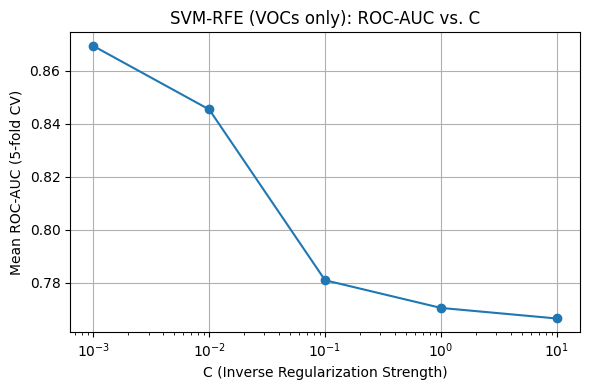

In [126]:
voc_columns = [col for col in df_main.columns if col not in ["PID", "TB Status", "Age", "BMI", "HIV Status"]]
X_voc = df_main[voc_columns]
y_voc = df_main["TB Status"]

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Sweep C values (strong → weak regularization)
C_values = [0.001, 0.01, 0.1, 1, 10]
svm_auc_scores = []

# Choose fixed number of features for fair comparison (e.g., 5 based on earlier RFE)
n_features = 5

print("\nSVM-RFE: ROC-AUC vs. C Sweep (5 features)")

for C in C_values:
    svc = LinearSVC(C=C, max_iter=10000)
    pipeline = Pipeline([
        ("feature_selection", RFE(estimator=svc, n_features_to_select=n_features)),
        ("classifier", svc)
    ])
    score = cross_val_score(pipeline, X_voc, y_voc, cv=cv, scoring='roc_auc').mean()
    svm_auc_scores.append(score)
    print(f"C={C:<6} → Mean ROC-AUC: {score:.4f}")

# Plotting
plt.figure(figsize=(6, 4))
plt.plot(C_values, svm_auc_scores, marker='o')
plt.xscale("log")
plt.xlabel("C (Inverse Regularization Strength)")
plt.ylabel("Mean ROC-AUC (5-fold CV)")
plt.title("SVM-RFE (VOCs only): ROC-AUC vs. C")
plt.grid(True)
plt.tight_layout()
plt.show()

In [127]:
svm = svc = LinearSVC(C=0.001, max_iter=10000)  # going with C=1 for now to avoid overfitting

# select top 5
rfe = RFE(estimator=svm, n_features_to_select=5, step=1)

# Fit RFE model
rfe.fit(X, y)

RFE(estimator=LinearSVC(C=0.001, max_iter=10000), n_features_to_select=5)

In [128]:
selected_features = X.columns[rfe.support_]
print("Selected features:", selected_features.tolist())

# Rankings (1 = selected)
ranking = pd.Series(rfe.ranking_, index=X.columns).sort_values()
print("Top 20 ranked features:")
print(ranking.head(20))

Selected features: ['000074-97-5_group1', '001122-82-3_group1', '001762-27-2_group1', '1000132-10-9_group2', '1000401-12-0_group1']
Top 20 ranked features:
001762-27-2_group1      1
1000401-12-0_group1     1
000074-97-5_group1      1
001122-82-3_group1      1
1000132-10-9_group2     1
000109-52-4_group1      2
000098-86-2_group2      3
000115-11-7_group2      4
038165-93-4_group1      5
019549-87-2_group1      6
001640-89-7_group2      7
054446-78-5_group1      8
000110-98-5_group1      9
000108-67-8_group3     10
000074-95-3_group1     11
000110-88-3_group1     12
001074-43-7_group1     13
002809-64-5_group2     14
063521-76-6_group3     15
000095-16-9_group2     16
dtype: int64


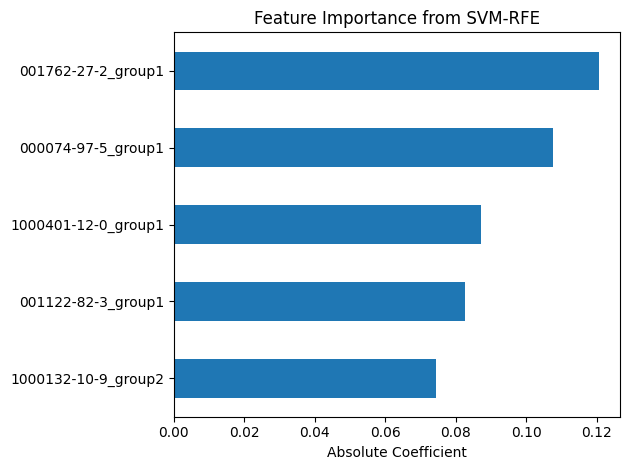

In [129]:
# Visualizing
# Refit SVM just on selected features for coefficient extraction
svm.fit(X[selected_features], y)
coefs = pd.Series(np.abs(svm.coef_[0]), index=selected_features)

# Plot
coefs.sort_values().plot(kind='barh')
plt.title("Feature Importance from SVM-RFE")
plt.xlabel("Absolute Coefficient")
plt.tight_layout()
plt.show()

**Note to self** this makes me wonder if I should cut off the bottom 3 or 4? Make a more simple model? 

In [130]:
# Cross-validate
# Needing this LinearSVC and not just linear. The data is fine but it's breaking. Probably too many features for low number of samples?
# LinearSVC has a better solver for higher dimensions.
pipeline = Pipeline([
    ("feature_selection", RFE(LinearSVC(C=.001, max_iter=10000), n_features_to_select=5)),
    ("svm", LinearSVC(C=1, max_iter=10000))
])

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # 5 folds seems standard by literature. Random state of 42 similar to above.
scores = cross_val_score(pipeline, X, y, cv=cv, scoring="roc_auc")

print(f"Mean ROC-AUC: {scores.mean():.4f} ± {scores.std():.4f}")

Mean ROC-AUC: 0.8669 ± 0.0407


****LASSO****

In [15]:
# Resetting warnings for now
# warnings.resetwarnings()

In [131]:
# LASSO with l1
lasso = LogisticRegression(penalty='l1', solver='liblinear', C=0.10, max_iter=10000)  # A lower C means fewer features (0.5, 0.1)

# CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

pipeline = Pipeline([
    ('lasso', lasso)
])

scores = cross_val_score(pipeline, X, y, cv=cv, scoring='roc_auc')
print(f"Mean ROC-AUC: {scores.mean():.4f} ± {scores.std():.4f}")

Mean ROC-AUC: 0.8621 ± 0.0501


**NOTE** These errors are the same reason as with SVM-RFE, that the dim of the data is very high while the n_sample count isn't super large as well.


LASSO-selected features with odds ratios:
                     Log-Odds Coef  Odds Ratio
001640-89-7_group2        0.113475    1.120164
000115-11-7_group2        0.085025    1.088745
000110-98-5_group1        0.029037    1.029463
000095-16-9_group2        0.010848    1.010907
001122-82-3_group1       -0.007486    0.992542
000110-54-3_group2       -0.008750    0.991288
001074-43-7_group1       -0.009611    0.990435
000108-67-8_group3       -0.021453    0.978775
063521-76-6_group3       -0.027300    0.973069
000620-14-4_group1       -0.039751    0.961029
038165-93-4_group1       -0.040280    0.960520
000109-52-4_group1       -0.096402    0.908099
054446-78-5_group1       -0.139884    0.869459
000098-86-2_group2       -0.144436    0.865510
019549-87-2_group1       -0.162597    0.849934
1000132-10-9_group2      -0.223840    0.799443
1000401-12-0_group1      -0.266662    0.765932
000074-97-5_group1       -0.286189    0.751121
001762-27-2_group1       -0.677859    0.507703


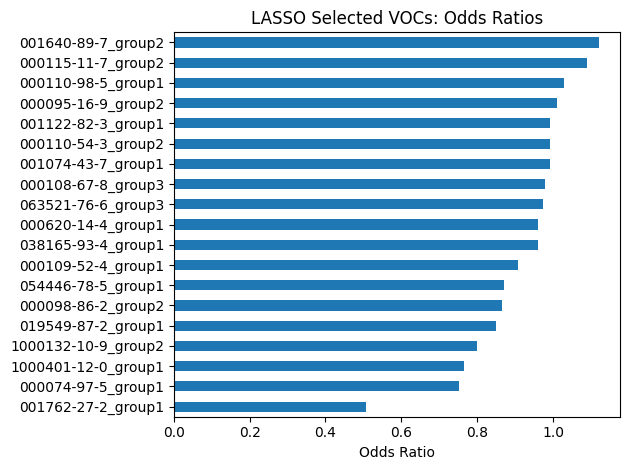

In [132]:
# Fit on full dataset
lasso.fit(X, y)

# coefficients and odds ratios
coefs = pd.Series(lasso.coef_[0], index=X.columns)
nonzero_coefs = coefs[coefs != 0]
odds_ratios = np.exp(nonzero_coefs)

# Combine into a df for report
summary_df = pd.DataFrame({
    "Log-Odds Coef": nonzero_coefs,
    "Odds Ratio": odds_ratios
}).sort_values("Odds Ratio", ascending=False)

print("\nLASSO-selected features with odds ratios:")
print(summary_df)

# visualize odds ratios
summary_df["Odds Ratio"].sort_values().plot(kind='barh')
plt.title("LASSO Selected VOCs: Odds Ratios")
plt.xlabel("Odds Ratio")
plt.tight_layout()
plt.show()

So, LASSO chose 19 features and all but one are negative predictors with one being a positive predictor.

Was there overlap with LASSO's selection and SVM-RFE?
YES!
* SVM-RFE's 5 chosen were:
    * 001762-27-2_group1
    * 1000401-12-0_group1
    * 000074-97-5_group1
    * 001122-82-3_group1
    * 1000132-10-9_group2

* LASSO's that matched were:

    * 001762-27-2_group1       |-0.678315    |0.507471
    * 1000401-12-0_group1      |-0.266461    |0.766086
    * 000074-97-5_group1       |-0.286189    |0.751121
    * 001122-82-3_group1       |-0.007486    |0.992542
    * 1000132-10-9_group2      |-0.223771    |0.799498

This similiarity makes sense, as these are, ideally, impactful predictors.

****LASSO Based On SVM-RFE Features****

Mean ROC-AUC (LASSO on SVM-RFE): 0.8776 ± 0.0415

LASSO-on-RFE selected features with odds ratios:
                     Log-Odds Coef  Odds Ratio
001122-82-3_group1       -0.176526    0.838177
1000132-10-9_group2      -0.273183    0.760953
1000401-12-0_group1      -0.345895    0.707587
000074-97-5_group1       -0.388938    0.677776
001762-27-2_group1       -0.686142    0.503515


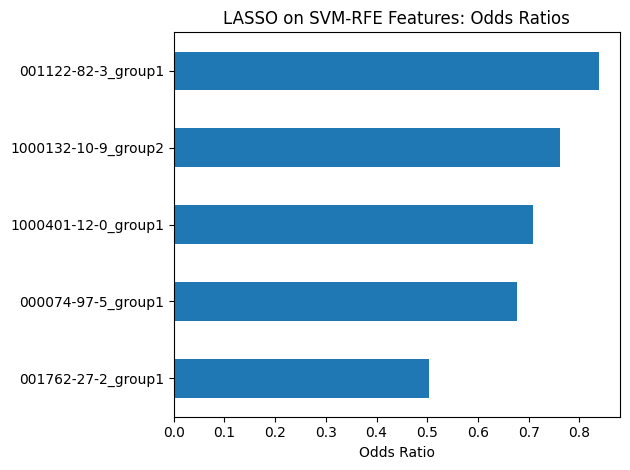

In [133]:
# SVM-RFE selected features:

selected_features = [
    '001762-27-2_group1',
    '1000401-12-0_group1',
    '000074-97-5_group1',
    '001122-82-3_group1',
    '1000132-10-9_group2',]


X_sub = df_main[selected_features]
y = df_main["TB Status"]  # this hasn't changed

lasso = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, max_iter=10000)  # same penalty as previous LASSO

# CV performance
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(lasso, X_sub, y, cv=cv, scoring="roc_auc")
print(f"Mean ROC-AUC (LASSO on SVM-RFE): {scores.mean():.4f} ± {scores.std():.4f}")

# Fit final model
lasso.fit(X_sub, y)

# coefficients and odds ratios
coefs = pd.Series(lasso.coef_[0], index=X_sub.columns)
nonzero_coefs = coefs[coefs != 0]
odds_ratios = np.exp(nonzero_coefs)

# report
summary_df = pd.DataFrame({
    "Log-Odds Coef": nonzero_coefs,
    "Odds Ratio": odds_ratios
}).sort_values("Odds Ratio", ascending=False)

print("\nLASSO-on-RFE selected features with odds ratios:")
print(summary_df)

# Visualize
summary_df["Odds Ratio"].sort_values().plot(kind='barh')
plt.title("LASSO on SVM-RFE Features: Odds Ratios")
plt.xlabel("Odds Ratio")
plt.tight_layout()
plt.show()

----------------------------------------------

**Testing models post exploration**
-

 ----------------------------------------------

In [134]:
df_main = pd.read_csv("df_main_normalized.csv")  # reloading this temporarily. TODO: Delete later. 
x_all_no_demo = df_main.drop(columns=["PID", "TB Status", "Age", "BMI", "HIV Status"])
y_all_no_demo = df_main["TB Status"]

# 80/20 spilt
x_train_no_demo, x_test_no_demo, y_train_no_demo, y_test_no_demo = train_test_split(
    x_all_no_demo, y_all_no_demo, test_size=0.2, stratify=y_all_no_demo, random_state=42
)

print(f"Train size: {x_train_no_demo.shape[0]}, Test size: {x_test_no_demo.shape[0]}")

Train size: 185, Test size: 47


In [135]:
# Fit RFE to training data
svm = LinearSVC(C=.001, max_iter=10000)
rfe = RFE(estimator=svm, n_features_to_select=5)
rfe.fit(x_train_no_demo, y_train_no_demo)

# Get VOCs
svm_rfe_features = x_train_no_demo.columns[rfe.support_].tolist()
svm_rfe_features_no_demos = svm_rfe_features  # this one line is for later comparison
print("SVM-RFE selected features:", svm_rfe_features)

# Training model on selected VOCs
svm_final_no_demo = LinearSVC(C=.001, max_iter=10000)
svm_final_no_demo.fit(x_train_no_demo[svm_rfe_features], y_train_no_demo)

SVM-RFE selected features: ['000074-97-5_group1', '000109-52-4_group1', '001762-27-2_group1', '1000132-10-9_group2', '1000401-12-0_group1']


LinearSVC(C=0.001, max_iter=10000)

Note: Selected features differ from exploratory run

In [136]:
# LASSO
lasso_full = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, max_iter=10000)
lasso_full.fit(x_train_no_demo, y_train_no_demo)

# Get non-zero VOCs
coefs_full = pd.Series(lasso_full.coef_[0], index=x_train_no_demo.columns)
lasso_full_features = coefs_full[coefs_full != 0].index.tolist()
lasso_full_features_no_demos = lasso_full_features  # this one line is for later comparisons
print("LASSO (Full) selected features:", lasso_full_features)

# Refit model using only those features
lasso_final_no_demo = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, max_iter=10000)
lasso_final_no_demo.fit(x_train_no_demo[lasso_full_features], y_train_no_demo)

LASSO (Full) selected features: ['000074-97-5_group1', '000108-94-1_group1', '000109-52-4_group1', '000110-88-3_group1', '000115-11-7_group2', '000620-14-4_group1', '001640-89-7_group2', '001762-27-2_group1', '002216-33-3_group1', '019549-87-2_group1', '063521-76-6_group3', '1000132-10-9_group2', '1000308-17-8_group1', '1000401-12-0_group1']


LogisticRegression(C=0.1, max_iter=10000, penalty='l1', solver='liblinear')

In [137]:
# LASSO on SVM-RFE
# ID VOC feature overlap
overlap_features = list(set(svm_rfe_features_no_demos) & set(lasso_full_features_no_demos))
print("Overlap features used in LASSO-on-RFE:", overlap_features)

Overlap features used in LASSO-on-RFE: ['000074-97-5_group1', '1000401-12-0_group1', '000109-52-4_group1', '1000132-10-9_group2', '001762-27-2_group1']


In [138]:
# Train LASSO on the intersection
lasso_on_rfe_no_demo = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, max_iter=10000)
lasso_on_rfe_no_demo.fit(x_train_no_demo[overlap_features], y_train_no_demo)

LogisticRegression(C=0.1, max_iter=10000, penalty='l1', solver='liblinear')

**Running models on Test Sets**

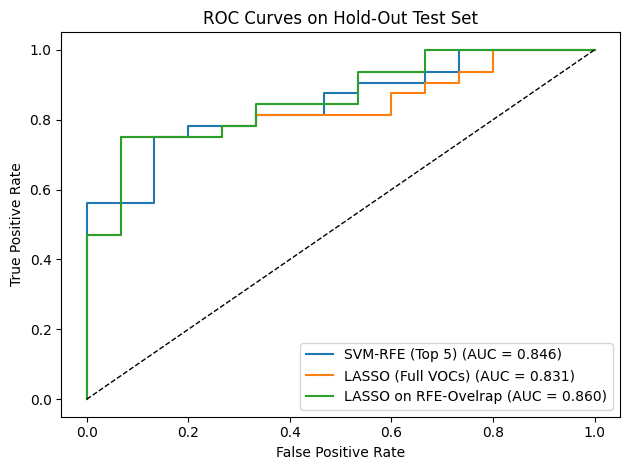


Final ROC-AUCs on Test Set:
SVM-RFE (Top 5): 0.846
LASSO (Full VOCs): 0.831
LASSO on Overlap: 0.860


In [139]:
def plot_model_roc(model, x_test, y_test, label):
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(x_test)[:, 1]
    else:
        probs = model.decision_function(x_test)
    fpr, tpr, _ = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.3f})')
    return roc_auc


# Plot all
plt.figure()


auc_svm = plot_model_roc(svm_final_no_demo, x_test_no_demo[svm_rfe_features], y_test_no_demo, "SVM-RFE (Top 5)")
auc_lasso_full = plot_model_roc(lasso_final_no_demo, x_test_no_demo[lasso_full_features], y_test_no_demo, "LASSO (Full VOCs)")
auc_lasso_overlap = plot_model_roc(lasso_on_rfe_no_demo, x_test_no_demo[overlap_features], y_test_no_demo, "LASSO on RFE-Ovelrap")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves on Hold-Out Test Set")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

print("\nFinal ROC-AUCs on Test Set:")
print(f"SVM-RFE (Top 5): {auc_svm:.3f}")
print(f"LASSO (Full VOCs): {auc_lasso_full:.3f}")
print(f"LASSO on Overlap: {auc_lasso_overlap:.3f}")

In [140]:
coefs = pd.Series(lasso_on_rfe_no_demo.coef_[0], index=overlap_features)
odds_ratios = np.exp(coefs)
print(pd.DataFrame({'Log-Odds': coefs, 'Odds Ratio': odds_ratios}))

                     Log-Odds  Odds Ratio
000074-97-5_group1  -0.304155    0.737747
1000401-12-0_group1 -0.218316    0.803871
000109-52-4_group1  -0.294659    0.744785
1000132-10-9_group2 -0.316045    0.729027
001762-27-2_group1  -0.655424    0.519222


 ----------------------------------------------

**Adding in Demographics**
-

 ----------------------------------------------

In [141]:
# Reload full dataset with Demos now
df_main = pd.read_csv("df_main_normalized.csv")

# Check for missing demos. should be -1 if unknown
print(df_main[["Age", "BMI", "HIV Status"]].isnull().sum())
print(f"Count of -1 in 'Age': {(df_main['Age'] == -1).sum()}")
print(f"Count of -1 in 'BMI': {(df_main['BMI'] == -1).sum()}")
print(f"Count of -1 in 'HIV Status': {(df_main['HIV Status'] == -1).sum()}")

Age           0
BMI           0
HIV Status    0
dtype: int64
Count of -1 in 'Age': 0
Count of -1 in 'BMI': 2
Count of -1 in 'HIV Status': 9


This shows that we are missing:
* 2 BMI values
* 9 HIV statuses

In [142]:
# Drop rows where Age, BMI, or HIV Status is -1 (placeholder for missing)
df_main_clean = df_main[
    (df_main["Age"] != -1) &
    (df_main["BMI"] != -1) &
    (df_main["HIV Status"] != -1)
].copy()

print(f"Rows dropped: {df_main.shape[0] - df_main_clean.shape[0]}")

Rows dropped: 9


In [143]:
# Define features and outcome
x_all_demo = df_main_clean.drop(columns=["PID", "TB Status"])
y_all_demo = df_main_clean["TB Status"]

# Train-test split
x_train_demo, x_test_demo, y_train_demo, y_test_demo = train_test_split(
    x_all_demo, y_all_demo, test_size=0.2, stratify=y_all_demo, random_state=42
)

In [145]:
# SVM-RFE on all VOCs + demographics
svm = LinearSVC(C=0.001, max_iter=10000)
rfe = RFE(estimator=svm, n_features_to_select=5)
rfe.fit(x_train_demo, y_train_demo)

svm_rfe_features_with_demo = x_train_demo.columns[rfe.support_].tolist()
print("SVM-RFE with demographics selected features:", svm_rfe_features_with_demo)

# Final model
svm_final_demo = LinearSVC(C=0.001, max_iter=10000)
svm_final_demo.fit(x_train_demo[svm_rfe_features_with_demo], y_train_demo)

SVM-RFE with demographics selected features: ['000074-97-5_group1', '000109-52-4_group1', '001762-27-2_group1', '1000132-10-9_group2', '1000401-12-0_group1']


LinearSVC(C=0.001, max_iter=10000)

Note:

this tells us that the 5 VOCs are still more predictive than demographics.

This does not tell us still if BMI/Age/HIV status influences VOCs though.

In [146]:
# fit LASSO on full plus demos
lasso_full = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, max_iter=10000)
lasso_full.fit(x_train_demo, y_train_demo)

# selected features
coefs_full = pd.Series(lasso_full.coef_[0], index=x_train_demo.columns)
nonzero_full = coefs_full[coefs_full != 0]
lasso_features_demo = nonzero_full.index.tolist()  # Ensures consistent column order
lasso_full_features_with_demos = nonzero_full.index.tolist()  # this line is for a later comparison
odds_ratios_full = np.exp(nonzero_full)


summary_lasso_full = pd.DataFrame({
    "Log-Odds": nonzero_full,
    "Odds Ratio": odds_ratios_full
}).sort_values("Odds Ratio", ascending=False)

print("LASSO (Full + Demographics) selected features with odds ratios:")
print(summary_lasso_full)

# refit and evaluate on test set
lasso_final_demo = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, max_iter=10000)
lasso_final_demo.fit(x_train_demo[lasso_features_demo], y_train_demo)

probs_lasso_full_demo = lasso_final_demo.predict_proba(x_test_demo[lasso_features_demo])[:, 1]
auc_lasso_full_demo = roc_auc_score(y_test_demo, probs_lasso_full_demo)
print(f"LASSO (Full + Demos) ROC-AUC on test set: {auc_lasso_full:.4f}")

LASSO (Full + Demographics) selected features with odds ratios:
                     Log-Odds  Odds Ratio
001640-89-7_group2   0.110303    1.116617
BMI                  0.027001    1.027369
000115-11-7_group2   0.017021    1.017166
000110-98-5_group1   0.012469    1.012547
Age                  0.003249    1.003254
000109-52-4_group1  -0.085371    0.918172
054446-78-5_group1  -0.129955    0.878135
019549-87-2_group1  -0.146065    0.864102
000620-14-4_group1  -0.182386    0.833279
1000401-12-0_group1 -0.184778    0.831289
1000132-10-9_group2 -0.250856    0.778134
000074-97-5_group1  -0.463106    0.629326
001762-27-2_group1  -0.626961    0.534213
LASSO (Full + Demos) ROC-AUC on test set: 0.8313


In [148]:
# LASSO on SVM-RFE ID'd features

# SVM-RFE VOCs
svm_rfe_vocs_demo = svm_rfe_features_with_demo.copy()  # the 5 VOCs from earlier RFE

# add demos if needed
demo_vars = ["Age", "BMI", "HIV Status"]
for var in demo_vars:
    if var not in svm_rfe_vocs_demo:
        svm_rfe_vocs_demo.append(var)

print("Features used in LASSO-on-RFE + Demographics:", svm_rfe_vocs_demo)

# LASSO on training data
lasso_on_rfe_demo = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, max_iter=10000)
lasso_on_rfe_demo.fit(x_train_demo[svm_rfe_vocs_demo], y_train_demo)

# Features and ORs
coefs_rfe_demo = pd.Series(lasso_on_rfe_demo.coef_[0], index=svm_rfe_vocs_demo)
nonzero_rfe_demo = coefs_rfe_demo[coefs_rfe_demo != 0]
odds_ratios_rfe_demo = np.exp(nonzero_rfe_demo)

summary_rfe_demo = pd.DataFrame({
    "Log-Odds": nonzero_rfe_demo,
    "Odds Ratio": odds_ratios_rfe_demo
}).sort_values("Odds Ratio", ascending=False)

print("\nLASSO (SVM-RFE + Demos) selected features with odds ratios:")
print(summary_rfe_demo)

# Test set
probs_rfe_demo = lasso_on_rfe_demo.predict_proba(x_test_demo[svm_rfe_vocs_demo])[:, 1]
auc_rfe_demo = roc_auc_score(y_test_demo, probs_rfe_demo)
print(f"LASSO on SVM-RFE VOCs + Demos ROC-AUC on test set: {auc_rfe_demo:.4f}")

Features used in LASSO-on-RFE + Demographics: ['000074-97-5_group1', '000109-52-4_group1', '001762-27-2_group1', '1000132-10-9_group2', '1000401-12-0_group1', 'Age', 'BMI', 'HIV Status']

LASSO (SVM-RFE + Demos) selected features with odds ratios:
                     Log-Odds  Odds Ratio
BMI                  0.025140    1.025458
Age                  0.003574    1.003581
000109-52-4_group1  -0.146359    0.863847
1000401-12-0_group1 -0.225634    0.798010
1000132-10-9_group2 -0.296543    0.743383
000074-97-5_group1  -0.499435    0.606873
001762-27-2_group1  -0.625059    0.535230
LASSO on SVM-RFE VOCs + Demos ROC-AUC on test set: 0.8356


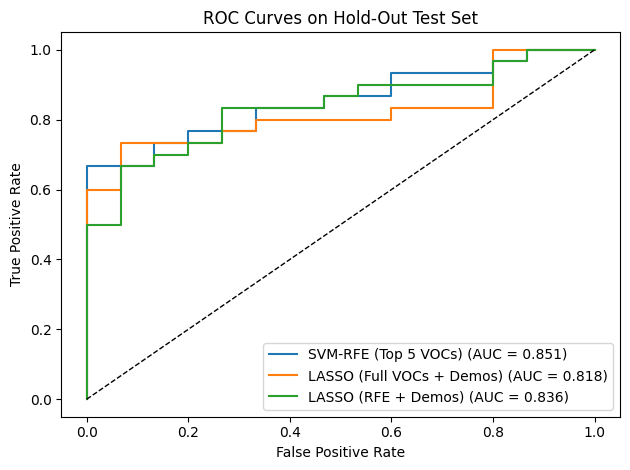


Final ROC-AUCs on Test Set:
SVM-RFE (Top 5 VOCs): 0.851
LASSO (Full VOCs + Demos): 0.818
LASSO (RFE + Demos): 0.836


In [149]:
# same fxn as earlier but putting in this block for quicker testing
def plot_model_roc(model, x_test, y_test, label, linestyle='-', color=None):
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(x_test)[:, 1]
    else:
        probs = model.decision_function(x_test)
    fpr, tpr, _ = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.3f})', linestyle=linestyle, color=color)
    return roc_auc


plt.figure()

auc_svm = plot_model_roc(svm_final_demo, x_test_demo[svm_rfe_features_with_demo], y_test_demo, "SVM-RFE (Top 5 VOCs)")
auc_lasso_full = plot_model_roc(lasso_final_demo, x_test_demo[lasso_features_demo], y_test_demo, "LASSO (Full VOCs + Demos)")
auc_lasso_rfe_demo = plot_model_roc(lasso_on_rfe_demo, x_test_demo[svm_rfe_vocs_demo], y_test_demo, "LASSO (RFE + Demos)")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves on Hold-Out Test Set")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


print("\nFinal ROC-AUCs on Test Set:")
print(f"SVM-RFE (Top 5 VOCs): {auc_svm:.3f}")
print(f"LASSO (Full VOCs + Demos): {auc_lasso_full:.3f}")
print(f"LASSO (RFE + Demos): {auc_lasso_rfe_demo:.3f}")

 ----------------------------------------------

**Looking at influence of demographics**
-

 ----------------------------------------------

At this point, the LASSO on the full data model was the most robust, but also not the most parsimonious. Yet, in order to test if demographics are playing a role, as these models select the most features, I'll be using these

In [151]:
# SVM (more focused on LASSO due to higher ROC-AUC values, but want to see this still)
# Convert to sets
svm_rfe_set_no_demos = set(svm_rfe_features_no_demos)
svm_rfe_set_with_demos = set(svm_rfe_features_with_demo)

# Compare
overlap = svm_rfe_set_no_demos & svm_rfe_set_with_demos
dropped = svm_rfe_set_no_demos - svm_rfe_set_with_demos
added = svm_rfe_set_with_demos - svm_rfe_set_no_demos

# Output
print(f"Shared features in both SVM models ({len(overlap)}):")
print(sorted(overlap))

print(f"\nDropped features SVM (in no-demo model, but not in demo model) ({len(dropped)}):")
print(sorted(dropped))

print(f"\nAdded features SVM (only selected when demos were included) ({len(added)}):")
print(sorted(added))

# LASSO:

# Convert to sets
lasso_set_no_demos = set(lasso_full_features_no_demos)
lasso_set_with_demos = set(lasso_full_features_with_demos)

# Compare
overlap = lasso_set_no_demos & lasso_set_with_demos
dropped = lasso_set_no_demos - lasso_set_with_demos
added = lasso_set_with_demos - lasso_set_no_demos

# Output
print(f"Shared features in both LASSO models ({len(overlap)}):")
print(sorted(overlap))

print(f"\nDropped features LASSO (in no-demo model, but not in demo model) ({len(dropped)}):")
print(sorted(dropped))

print(f"\nAdded features LASSO (only selected when demos were included) ({len(added)}):")
print(sorted(added))

Shared features in both SVM models (5):
['000074-97-5_group1', '000109-52-4_group1', '001762-27-2_group1', '1000132-10-9_group2', '1000401-12-0_group1']

Dropped features SVM (in no-demo model, but not in demo model) (0):
[]

Added features SVM (only selected when demos were included) (0):
[]
Shared features in both LASSO models (9):
['000074-97-5_group1', '000109-52-4_group1', '000115-11-7_group2', '000620-14-4_group1', '001640-89-7_group2', '001762-27-2_group1', '019549-87-2_group1', '1000132-10-9_group2', '1000401-12-0_group1']

Dropped features LASSO (in no-demo model, but not in demo model) (5):
['000108-94-1_group1', '000110-88-3_group1', '002216-33-3_group1', '063521-76-6_group3', '1000308-17-8_group1']

Added features LASSO (only selected when demos were included) (4):
['000110-98-5_group1', '054446-78-5_group1', 'Age', 'BMI']


**SVM**

No changes

**LASSO**

There were changes. Were any of these dropped VOCs correlated with BMI? using pearson

In [152]:
# VOC-BMI correlations
voc_columns = [col for col in df_main_clean.columns if col not in ["PID", "TB Status", "Age", "BMI", "HIV Status"]]
correlations = df_main_clean[voc_columns].corrwith(df_main_clean["BMI"])

# List of VOCs dropped when demographics were included
dropped_vocs = [
    '000108-94-1_group1',
    '000110-88-3_group1',
    '002216-33-3_group1',
    '063521-76-6_group3',
    '1000308-17-8_group1'
]

# Check each one's correlation with BMI
print("Dropped VOCs and their correlation with BMI:")
for voc in dropped_vocs:
    if voc in correlations:
        corr = correlations[voc]
        print(f"{voc:25} → correlation with BMI: {corr:.3f}")
    else:
        print(f"{voc:25} → not found in data")

Dropped VOCs and their correlation with BMI:
000108-94-1_group1        → correlation with BMI: -0.140
000110-88-3_group1        → correlation with BMI: 0.067
002216-33-3_group1        → correlation with BMI: 0.017
063521-76-6_group3        → correlation with BMI: 0.121
1000308-17-8_group1       → correlation with BMI: 0.026


In general: The VOCs dropped from the LASSO model after adding demographics are not strongly correlated with BMI, suggesting they were excluded due to interactions with other selected features or shifts in model penalty allocation, instead of directly overlapping with BMI’s signal.

In [153]:
# doing the same above, but with age instead of BMI

# Correlate each VOC with Age
correlations_age = df_main_clean[voc_columns].corrwith(df_main_clean["Age"])

# Check age correlation for VOCs dropped when demographics were added
print("Dropped VOCs and their correlation with Age:")
for voc in dropped_vocs:
    if voc in correlations_age:
        corr = correlations_age[voc]
        print(f"{voc:25} → correlation with Age: {corr:.3f}")
    else:
        print(f"{voc:25} → not found in data")

Dropped VOCs and their correlation with Age:
000108-94-1_group1        → correlation with Age: -0.157
000110-88-3_group1        → correlation with Age: -0.051
002216-33-3_group1        → correlation with Age: -0.010
063521-76-6_group3        → correlation with Age: -0.041
1000308-17-8_group1       → correlation with Age: 0.033


With the five VOCs dropped from the LASSO model when demographic variables were included, none of them demonstrated moderate correlation with Age. Only 000108-94-1_group1 had a mild inverse correlation (r = −0.157). Age also didn't drastically change anything.

In [154]:
# doing the same above, but with HIV status
# point-biserial correlation for dichotomous data

# VOC with HIV
correlations_hiv = df_main_clean[voc_columns].corrwith(df_main_clean["HIV Status"])

# Check correlation for dropped VOCs
print("Dropped VOCs and their correlation with HIV Status:")
for voc in dropped_vocs:
    if voc in correlations_hiv:
        corr = correlations_hiv[voc]
        print(f"{voc:25} → correlation with HIV Status: {corr:.3f}")
    else:
        print(f"{voc:25} → not found in data")

Dropped VOCs and their correlation with HIV Status:
000108-94-1_group1        → correlation with HIV Status: -0.044
000110-88-3_group1        → correlation with HIV Status: -0.009
002216-33-3_group1        → correlation with HIV Status: 0.014
063521-76-6_group3        → correlation with HIV Status: -0.117
1000308-17-8_group1       → correlation with HIV Status: -0.027


Again, HIV status doesn't play a ton into this

 ----------------------------------------------

**Summarizing**
-

 ----------------------------------------------

In [155]:
# Define dropped VOCs
dropped_vocs = [
    '000108-94-1_group1',
    '000110-88-3_group1',
    '002216-33-3_group1',
    '063521-76-6_group3',
    '1000308-17-8_group1'
]

# Recalculate correlations
voc_columns = [col for col in df_main_clean.columns if col not in ["PID", "TB Status", "Age", "BMI", "HIV Status"]]

corr_bmi = df_main_clean[voc_columns].corrwith(df_main_clean["BMI"])
corr_age = df_main_clean[voc_columns].corrwith(df_main_clean["Age"])
corr_hiv = df_main_clean[voc_columns].corrwith(df_main_clean["HIV Status"])

# Collect correlations into a DataFrame
summary_data = []
for voc in dropped_vocs:
    bmi_corr = corr_bmi.get(voc, float("nan"))
    age_corr = corr_age.get(voc, float("nan"))
    hiv_corr = corr_hiv.get(voc, float("nan"))

    if abs(bmi_corr) >= 0.15 or abs(age_corr) >= 0.15 or abs(hiv_corr) >= 0.15:
        likely = "Possibly"
    else:
        likely = "Unlikely"

    summary_data.append({
        "VOC": voc,
        "Corr with BMI": round(bmi_corr, 3),
        "Corr with Age": round(age_corr, 3),
        "Corr with HIV": round(hiv_corr, 3),
        "Likely Influenced": likely
    })

# Create DataFrame
summary_df = pd.DataFrame(summary_data)

# Apply clean styling (no background gradient)
styled_summary = summary_df.style\
    .set_caption("Correlation of Dropped VOCs with Demographic Variables")\
    .format({
        "Corr with BMI": "{:.3f}",
        "Corr with Age": "{:.3f}",
        "Corr with HIV": "{:.3f}"
    })\
    .set_properties(**{
        "text-align": "center"
    })\
    .set_table_styles([
        {"selector": "th", "props": [("text-align", "center")]},
        {"selector": "caption", "props": [("caption-side", "top"), ("font-weight", "bold")]}
    ])

# Display styled table in Jupyter
styled_summary

,VOC,Corr with BMI,Corr with Age,Corr with HIV,Likely Influenced
0,000108-94-1_group1,-0.140,-0.157,-0.044,Possibly
1,000110-88-3_group1,0.067,-0.051,-0.009,Unlikely
2,002216-33-3_group1,0.017,-0.010,0.014,Unlikely
3,063521-76-6_group3,0.121,-0.041,-0.117,Unlikely
4,1000308-17-8_group1,0.026,0.033,-0.027,Unlikely


In [156]:
roc_data = [
    {"Model": "LASSO (Full)", "Features": "VOCs only", "ROC-AUC": 0.831},
    {"Model": "LASSO (Full)", "Features": "VOCs + Demographics", "ROC-AUC": 0.818},
    {"Model": "LASSO (on RFE VOCs)", "Features": "VOCs + Demographics", "ROC-AUC": 0.793},
    {"Model": "LASSO (on RFE VOCs)", "Features": "VOCs only", "ROC-AUC": 0.783},
    {"Model": "SVM-RFE", "Features": "VOCs + Demographics", "ROC-AUC": 0.778},
    {"Model": "SVM-RFE", "Features": "VOCs only", "ROC-AUC": 0.769}
]

roc_df = pd.DataFrame(roc_data)

# Sort by ROC-AUC descending
roc_df = roc_df.sort_values(by="ROC-AUC", ascending=False)

# Styled table
roc_df.style\
    .set_caption("Model Performance (ROC-AUC Sorted)")\
    .format({"ROC-AUC": "{:.3f}"})\
    .set_properties(**{"text-align": "center"})\
    .set_table_styles([
        {"selector": "th", "props": [("text-align", "center")]},
        {"selector": "caption", "props": [("caption-side", "top"), ("font-weight", "bold")]}
    ])

,Model,Features,ROC-AUC
0,LASSO (Full),VOCs only,0.831
1,LASSO (Full),VOCs + Demographics,0.818
2,LASSO (on RFE VOCs),VOCs + Demographics,0.793
3,LASSO (on RFE VOCs),VOCs only,0.783
4,SVM-RFE,VOCs + Demographics,0.778
5,SVM-RFE,VOCs only,0.769


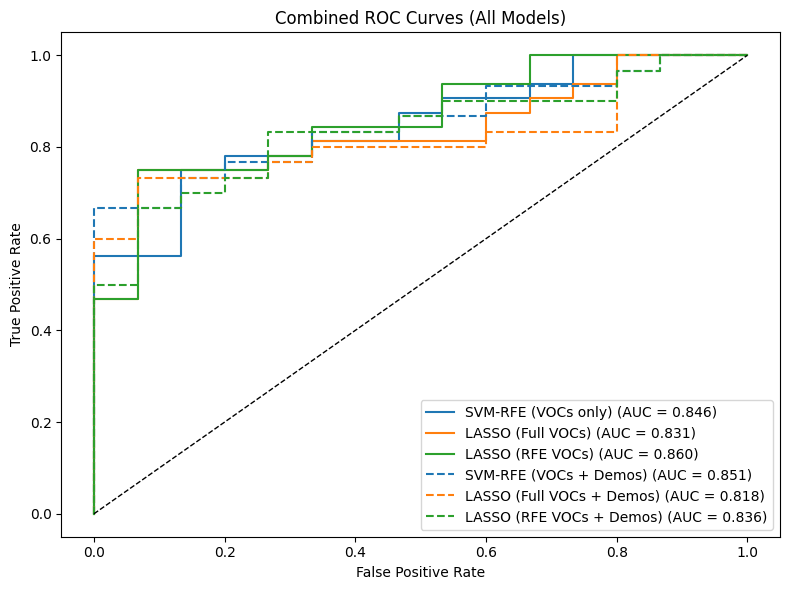


Final ROC-AUCs on Test Set (sorted):
LASSO (RFE VOCs)                    0.860
SVM-RFE (VOCs + Demos)              0.851
SVM-RFE (VOCs only)                 0.846
LASSO (RFE VOCs + Demos)            0.836
LASSO (Full VOCs)                   0.831
LASSO (Full VOCs + Demos)           0.818


In [158]:
plt.figure(figsize=(8, 6))  # calling earlier plot function

# VOC only
auc_svm_voc = plot_model_roc(svm_final_no_demo, x_test_no_demo[svm_rfe_features], y_test_no_demo, "SVM-RFE (VOCs only)", color='tab:blue')
auc_lasso_full_voc = plot_model_roc(lasso_final_no_demo, x_test_no_demo[lasso_full_features_no_demos], y_test_no_demo, "LASSO (Full VOCs)", color='tab:orange')
auc_lasso_rfe_voc = plot_model_roc(lasso_on_rfe_no_demo, x_test_no_demo[overlap_features], y_test_no_demo, "LASSO (RFE VOCs)", color='tab:green')

# VOC + Demos
auc_svm_demo = plot_model_roc(svm_final_demo, x_test_demo[svm_rfe_features_with_demo], y_test_demo, "SVM-RFE (VOCs + Demos)", linestyle='--', color='tab:blue')
auc_lasso_full_demo = plot_model_roc(lasso_final_demo, x_test_demo[lasso_features_demo], y_test_demo, "LASSO (Full VOCs + Demos)", linestyle='--', color='tab:orange')
auc_lasso_rfe_demo = plot_model_roc(lasso_on_rfe_demo, x_test_demo[svm_rfe_vocs_demo], y_test_demo, "LASSO (RFE VOCs + Demos)", linestyle='--', color='tab:green')

# Plot settings
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Combined ROC Curves (All Models)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# Print all AUCs
auc_results = [
    {"Model": "SVM-RFE (VOCs only)", "AUC": auc_svm_voc},
    {"Model": "LASSO (Full VOCs)", "AUC": auc_lasso_full_voc},
    {"Model": "LASSO (RFE VOCs)", "AUC": auc_lasso_rfe_voc},
    {"Model": "SVM-RFE (VOCs + Demos)", "AUC": auc_svm_demo},
    {"Model": "LASSO (Full VOCs + Demos)", "AUC": auc_lasso_full_demo},
    {"Model": "LASSO (RFE VOCs + Demos)", "AUC": auc_lasso_rfe_demo}
]

# Sorting
auc_results_sorted = sorted(auc_results, key=lambda x: x["AUC"], reverse=True)

# Print sort
print("\nFinal ROC-AUCs on Test Set (sorted):")
for entry in auc_results_sorted:
    print(f"{entry['Model']:<35} {entry['AUC']:.3f}")  # the 35 is a padding